In [1]:
import pennylane as qml
from pennylane import numpy as np
from functools import partial
import matplotlib.pyplot as plt

In [2]:
from datasets import *

# train_X, test_X, train_y, test_y = get_xor_data(200)
train_X, test_X, train_y, test_y = get_circular_boundary_dataset(500)
len(train_X)

450

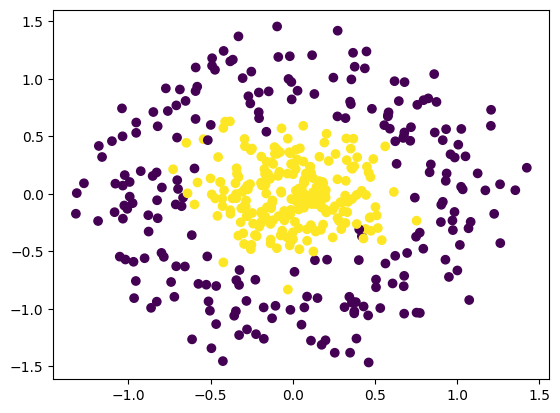

In [3]:
plot_2d_data(train_X,train_y)

In [4]:
s_params_size=1

In [5]:
dev = qml.device("default.qubit", wires=1)

def encode_and_rotate(x_i,s_params,w_params): 
    # input vector x   
    rx_angle = -2*s_params[0]*x_i[0]    
    ry_angle = -2*s_params[0]*x_i[1]
    qml.RY(ry_angle,0)
    qml.RX(rx_angle,0)
    qml.RX(-2*w_params[0],0)    
    qml.RY(-2*w_params[1],0)
    qml.RZ(-2*w_params[2],0)    

In [6]:
@qml.qnode(dev)
def vqc_model(x_i, params):
    s_params,w_params = params[:s_params_size], params[s_params_size:]
    encode_and_rotate(x_i, s_params,w_params)
    return qml.expval(qml.PauliZ(0))
@qml.qnode(dev)
def get_state(x_i,params):
    s_params,w_params = params[:s_params_size], params[s_params_size:]
    encode_and_rotate(x_i, s_params,w_params)
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))]


In [7]:
def loss(data, labels, model, params):    
    loss_sum = []
    for idx in range(len(data)):
        data_point = data[idx]
        true_label = labels[idx]
        model_output = model(data_point, params)
        if (model_output<0 and true_label>0) or (model_output>0 and true_label<0):
#             print(model_output, true_label)
            loss_sum.append((model_output - true_label) ** 2)

    return sum(loss_sum)/len(data)
#     return sum(loss_sum)/len(loss_sum)
#     return loss_sum / len(data)


def make_prediction(model, data_point, params):
    measurement_result = model(data_point, params)
    if measurement_result < 0:
        return -1
    return 1


def compute_accuracy(data, labels, model, params):
    n_samples = len(data)
#     for x in range(n_samples):
#         print(make_prediction(model, data[x], params),labels[x])
    return np.sum(
        [make_prediction(model, data[x], params) == labels[x] for x in range(n_samples)
    ]) / n_samples

In [8]:
def get_initial_dataset(train_X,train_Y):
    size_to_return = int(0.04*len(train_X))
    curr_train_X, curr_train_y = [],[]
    idx = np.random.choice(len(train_X), size_to_return)
    for i in idx:
        curr_train_X.append(train_X[i])        
        curr_train_y.append(train_Y[i])
    curr_train_X = np.array(curr_train_X, requires_grad=False)
    curr_train_y = np.array(curr_train_y, requires_grad=False)
    return curr_train_X,curr_train_y

In [9]:
# start_point_itrs = 50

# for _ in range(start_point_itrs):
# print("__________________________________________________")
s_params_size, w_params_size = 1,3
# params = np.random.normal(size=(s_params_size+w_params_size))#*100
params = np.array([ 1.00302379, -0.03861783,  0.08039802,  1.81841197]) # these weights work very well with circular boundary
print(params)
# opt = qml.AdamOptimizer(stepsize=0.00087)
opt = qml.GradientDescentOptimizer(stepsize=0.009)
num_its = 220
loss_over_time = []
# curr_train_X, curr_train_y = get_initial_dataset(train_X,train_y)
for itr in range(num_its):
    (_, _, _, params), _loss = opt.step_and_cost(loss, train_X, train_y, vqc_model, params)
    loss_over_time.append(_loss)
    print("Iteration:",itr, "Loss:",_loss)



[ 1.00302379 -0.03861783  0.08039802  1.81841197]
Iteration: 0 Loss: 0.21264669101692044
Iteration: 1 Loss: 0.21343383513789882
Iteration: 2 Loss: 0.212043423293178
Iteration: 3 Loss: 0.2062873037966219
Iteration: 4 Loss: 0.20506963196975558
Iteration: 5 Loss: 0.20386515302514627
Iteration: 6 Loss: 0.20267392433570502
Iteration: 7 Loss: 0.2014959940110424
Iteration: 8 Loss: 0.20258106279940527
Iteration: 9 Loss: 0.20150306366522908
Iteration: 10 Loss: 0.20043815402987789
Iteration: 11 Loss: 0.19941656197999513
Iteration: 12 Loss: 0.1984458790918
Iteration: 13 Loss: 0.1974873242890991
Iteration: 14 Loss: 0.1965408608440722
Iteration: 15 Loss: 0.19783548792308608
Iteration: 16 Loss: 0.19254389191839522
Iteration: 17 Loss: 0.19399010692647942
Iteration: 18 Loss: 0.19324030932330075
Iteration: 19 Loss: 0.19250061482625935
Iteration: 20 Loss: 0.19178488256832976
Iteration: 21 Loss: 0.1911292341298216
Iteration: 22 Loss: 0.18829223313698618
Iteration: 23 Loss: 0.1877504062789057
Iteration: 2

Iteration: 203 Loss: 0.1605247908825766
Iteration: 204 Loss: 0.15830131942699083
Iteration: 205 Loss: 0.16052219591616151
Iteration: 206 Loss: 0.15829857638030367
Iteration: 207 Loss: 0.1605196784903741
Iteration: 208 Loss: 0.1605183155876486
Iteration: 209 Loss: 0.1582948303211284
Iteration: 210 Loss: 0.1605159118024307
Iteration: 211 Loss: 0.16051460537410542
Iteration: 212 Loss: 0.16051358017790443
Iteration: 213 Loss: 0.16051264751333824
Iteration: 214 Loss: 0.16051139031303818
Iteration: 215 Loss: 0.1605101518428394
Iteration: 216 Loss: 0.16273116419181677
Iteration: 217 Loss: 0.16050806242072432
Iteration: 218 Loss: 0.1605068737902317
Iteration: 219 Loss: 0.16272820702810512


In [13]:
training_accuracy = compute_accuracy(train_X, train_y, vqc_model, params)
testing_accuracy = compute_accuracy(test_X, test_y, vqc_model, params)

print(f"Training accuracy = {training_accuracy}")
print(f"Testing accuracy = {testing_accuracy}")

Training accuracy = 0.8733333333333333
Testing accuracy = 0.88


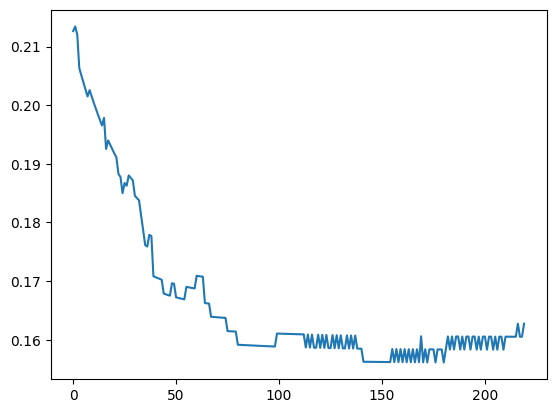

In [14]:
plt.plot(loss_over_time)
plt.show()

In [15]:
params

tensor([ 1.12647592, -0.01579637,  0.00447528,  1.81841197], requires_grad=True)

In [16]:

op_state = []
X,Y,Z=[],[],[]
markers=[]
colors=[]
for i in range(len(train_X)):
    x,y,z = (get_state(train_X[i],params))
    X.append(x)
    Y.append(y)
    Z.append(z)
    if train_y[i]==1:
        markers.append("o")
        colors.append('b')
    else:
        markers.append("^")
        colors.append('r')
    op_state.append([y,z])
op_state = np.array(op_state)
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)




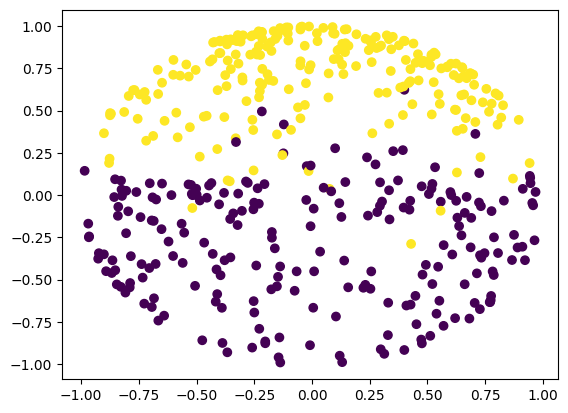

In [17]:
plot_2d_data(op_state,train_y)

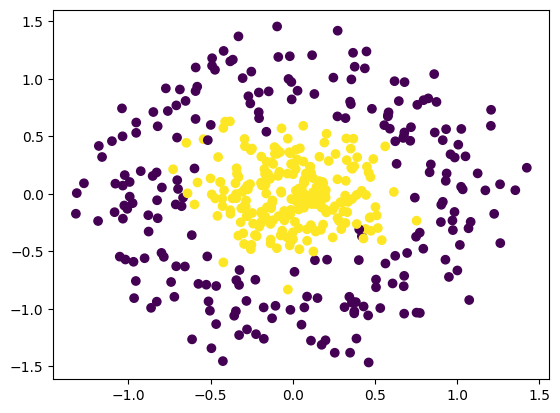

In [18]:
plot_2d_data(train_X,train_y)

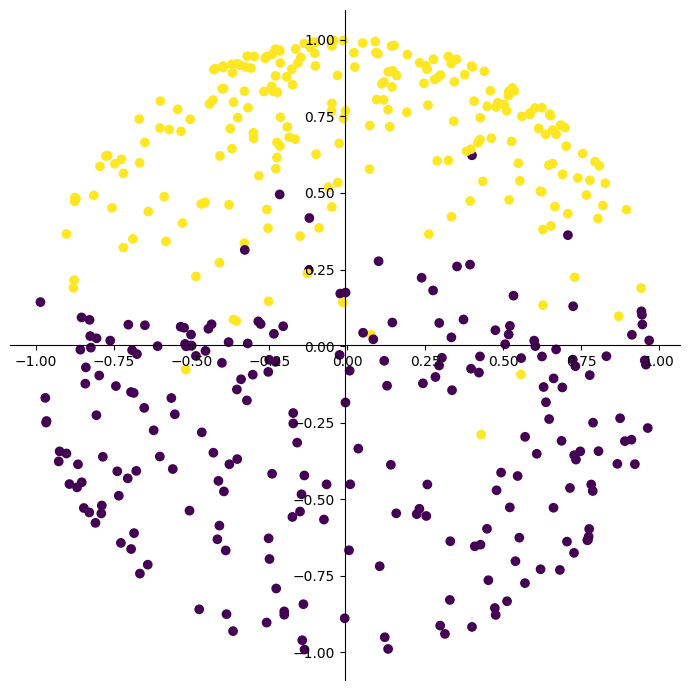

In [19]:
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.scatter(op_state[:, 0], op_state[:, 1], c=train_y)
# plt.legend(loc=1)
plt.show()

In [17]:
# https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html
# when benchmarking the WINE and IRIS for ternary classification